# Major Projects 20 Questions : Classification and Feature Engineering

In [1]:
# Data Source: https://majorprojects.alberta.ca/
# Major Projects are valued at $5 million or greater

## Data Preparation

Import necessary libraries

In [105]:
import pandas as pd
import json
# !pip install folium # Uncomment it to install
import folium # map rendering library
import sqlite3
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
# !conda install -c conda-forge pydotplus -y # Uncomment it to install
# !conda install -c conda-forge python-graphviz -y # Uncomment it to install
import io
import pydotplus
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import tree

Create a Pandas DataFrame from a Excel file

In [3]:
data = pd.read_excel('./Major Projects Export.xlsx')
print(data.shape)
data.head()

(710, 14)


,ProjectId,Name,Estimated Cost,Municipality,Schedule,Sector,Type,Stage,Developer,Contractor,Architect,Project Website,Location,Detail
0,7,StoneGate Landing,3.000000e+09,Calgary,2010 - 2021,Mixed-Use,NaN,Under Construction,WAM Development Group / AIMCo,NaN,NaN,www.stonegatelanding.ca/,"{""type"":""Feature"",""geometry"":{""type"":""Point"",""...",StoneGate Landing is slated to be the largest ...
1,11,Shepard Station Suburban Office Campus Building 1,2.200000e+07,Calgary,2019 - 2020,Commercial,Office: Low-Rise,Under Construction,Shepard Development Corp.,Shepard Development Corporation / CANA / ACE C...,NaN,http://www.shepardstation.com/,"{""type"":""Feature"",""geometry"":{""type"":""Point"",""...",The Shepard Suburban Office Campus is a 33-acr...
2,22,Barron Building Renovation,1.000000e+08,Calgary,Commencing 2021,Residential,Apartment: Mid-Rise,Proposed,Strategic Group,NaN,NaN,https://www.strategicgroup.ca/commercial/calga...,"{""type"":""Feature"",""geometry"":{""type"":""Point"",""...",Conversion of the Barron Building into a 94 un...
3,26,Quarry Crossing II Office Building,7.280000e+07,Calgary,NaN,Commercial,Office: Low-Rise,Proposed,Remington Development Corp.,NaN,NaN,http://www.remingtoncorp.com/leasingLocation.p...,"{""type"":""Feature"",""geometry"":{""type"":""Point"",""...","A 512,000 sq ft office building project in Cal..."
4,32,Nolan Hill TownHomes,5.000000e+06,Calgary,NaN,Residential,Townhouses,Proposed,Jayman Modus,NaN,NaN,NaN,"{""type"":""Feature"",""geometry"":{""type"":""Point"",""...",NaN


Extract from geojson the start location coordinates (Longitude, Latitude)

In [4]:
data['Location'] = data['Location'].apply(json.loads)

Latitude = []
Longitude = []

for i in range(len(data)):
    geo = data['Location'][i]['geometry']
    if geo['type'] == 'Point':
        Longitude.append(geo['coordinates'][0])
        Latitude.append(geo['coordinates'][1])
    elif geo['type'] == 'LineString':
            Longitude.append(geo['coordinates'][0][0])
            Latitude.append(geo['coordinates'][0][1])
    elif geo['geometries'][0]['type'] == 'Point':
            Longitude.append(data['Location'][i]['geometry']['geometries'][0]['coordinates'][0])
            Latitude.append(data['Location'][i]['geometry']['geometries'][0]['coordinates'][1])
    elif geo['geometries'][0]['type'] == 'LineString':
            Longitude.append(data['Location'][i]['geometry']['geometries'][0]['coordinates'][0][0])
            Latitude.append(data['Location'][i]['geometry']['geometries'][0]['coordinates'][0][1])
    else:
        print('Error: New Type')
        
data['Start Latitude'] = Latitude
data['Start Longitude'] = Longitude

Drop rows where there is no Estimated Cost and divide cost by a million

In [5]:
data = data.dropna(subset=['Estimated Cost'])
data['Estimated Cost'] = data['Estimated Cost']/(1e6)
data.shape

(702, 16)

Change Schedule Completion, assume 2027 for all proposed Project w/o Schedule

In [6]:
data['Schedule'] = data['Schedule'].str[-4:]
data['Schedule'] = data['Schedule'].fillna(2027)
data['Schedule'] = data['Schedule'].astype(int)

Rename Colums

In [7]:
data.rename(columns={'Name':'Project Name', 'Estimated Cost':'Estimated Cost (millions)', 'Schedule':'Forecasted Completion'}, inplace=True)

Assume that Projects that were under construction before 2020 are complete(unless are Cancelled or On Hold)

In [8]:
data.loc[data['Forecasted Completion']<2020, 'Stage']='Completed'
data['Stage'] = data['Stage'].replace('Under Construction','Started')
data['Stage'].value_counts()

Proposed     323
Started      311
Completed     68
Name: Stage, dtype: int64

Make Type equal to Sector when there is no type (except Infrastructure)

In [9]:
data['Type'] = data['Type'].fillna(data['Sector'])
data['Type'] = data['Type'].replace('Infrastructure','Other')

Drop columns not needed and set ProjectId as index

In [10]:
data.drop(columns=['Contractor','Architect','Project Website', 'Detail', 'Location'], inplace=True)
data.set_index('ProjectId',inplace=True)
data.head()

,Project Name,Estimated Cost (millions),Municipality,Forecasted Completion,Sector,Type,Stage,Developer,Start Latitude,Start Longitude
ProjectId,,,,,,,,,,
7,StoneGate Landing,3000.0,Calgary,2021,Mixed-Use,Mixed-Use,Started,WAM Development Group / AIMCo,51.172501,-113.975800
11,Shepard Station Suburban Office Campus Building 1,22.0,Calgary,2020,Commercial,Office: Low-Rise,Started,Shepard Development Corp.,50.931721,-113.970596
22,Barron Building Renovation,100.0,Calgary,2021,Residential,Apartment: Mid-Rise,Proposed,Strategic Group,51.046070,-114.076614
26,Quarry Crossing II Office Building,72.8,Calgary,2027,Commercial,Office: Low-Rise,Proposed,Remington Development Corp.,50.966900,-114.002899
32,Nolan Hill TownHomes,5.0,Calgary,2027,Residential,Townhouses,Proposed,Jayman Modus,51.162041,-114.160912


In [11]:
data.isnull().any()

Project Name                 False
Estimated Cost (millions)    False
Municipality                 False
Forecasted Completion        False
Sector                       False
Type                         False
Stage                        False
Developer                    False
Start Latitude               False
Start Longitude              False
dtype: bool

## Data Exploration

### Descriptive Statistics

In [12]:
data.describe(include=[object]).transpose()

,count,unique,top,freq
Project Name,702,702,Whistlers Campground Rebuild,1
Municipality,702,148,Calgary,184
Sector,702,11,Infrastructure,158
Type,702,56,Roadwork,79
Stage,702,3,Proposed,323
Developer,702,416,City of Edmonton,33


In [13]:
data.describe(exclude=['int64','object']).transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
Estimated Cost (millions),702.0,219.99,967.22,5.00,10.02,22.55,71.80,16000.00
Forecasted Completion,702.0,2022.10,3.12,2014.00,2020.00,2021.00,2024.00,2027.00
Start Latitude,702.0,52.51,1.81,49.02,51.04,52.75,53.55,58.48
Start Longitude,702.0,-113.80,1.62,-119.77,-114.08,-113.71,-113.39,-110.01


The Most Expensive Projects are (above $5m):

In [14]:
data[data['Estimated Cost (millions)']>5000]

,Project Name,Estimated Cost (millions),Municipality,Forecasted Completion,Sector,Type,Stage,Developer,Start Latitude,Start Longitude
ProjectId,,,,,,,,,,
614,Trans Mountain Pipeline Expansion,7400.0,Yellowhead County|Improvement District No. 12 ...,2019,Pipelines,Pipelines,Completed,Government of Canada/Trans Mountain Corporation,53.543042,-113.361502
873,"Green Line LRT, Stage 1",5500.0,Calgary,2026,Infrastructure,Transit,Proposed,City of Calgary,50.931484,-113.968971
3579,Keystone XL,10000.0,Cypress County|Provost No. 52|Special Area No....,2020,Pipelines,Pipelines,Started,TransCanada Energy Ltd.,52.635032,-111.275432
3735,SinoCan Global Upgrader and Petrochemical Faci...,8500.0,Lamont County,2021,Oil and Gas,Upgrader,Proposed,SinoCan Global,53.775939,-112.825255
3921,Telus Infrastructure Upgrades (Province wide),16000.0,Edmonton,2024,Industrial,Telecommunication,Started,TELUS,53.540116,-113.491361


Names and Number of unique project types

In [15]:
print(data.Type.unique())
len(data.Type.unique())

['Mixed-Use' 'Office: Low-Rise' 'Apartment: Mid-Rise' 'Townhouses'
 'Distribution Centre' 'Arts and Culture' 'Business Park' 'Roadwork'
 'Transit' 'Office Renovation' 'Research Centre' 'Shopping Plaza'
 'Apartment: High-Rise' 'Telecommunication' 'Water/Wastewater' 'Other'
 'Airport' 'Emergency Services' 'Flood Mitigation' 'Health Care'
 'Administration' 'Post-Secondary' 'Library' 'Continuing Care'
 'Student Residence' 'Religious' 'School' 'Gas' 'Oil Sands: In Situ'
 'Oil Sands: Mining' 'Upgrader' 'Bioproduct' 'Chemical' 'Metals'
 'Military' 'Pipelines' 'Natural Gas' 'Wind' 'Apartment: Low-Rise'
 'Attractions' 'Sports Facility' 'Hotel' 'Park' 'Museum' 'Solar'
 'Event Space' 'Community Centre' 'Agriculture' 'Community' 'Power Centre'
 'Transmission Line' 'Distribution/Storage' 'Big-Box Store'
 'Shopping Mall' 'Auto Dealership' 'Bioenergy']


56

### Bar Chart of Project Types

<AxesSubplot:>

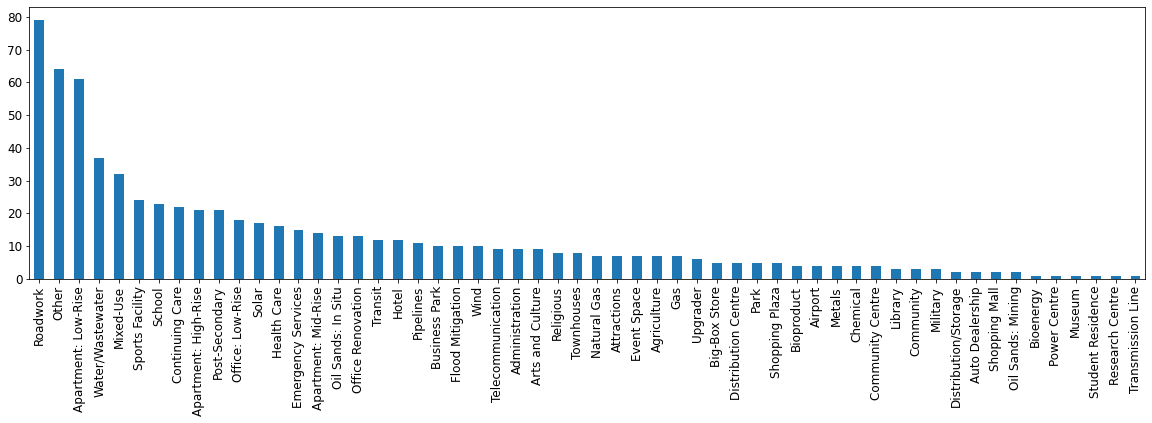

In [16]:
data.Type.value_counts().plot.bar(figsize = [20, 5], fontsize = 12)

The Projects types with only 1 or 2 Projects are:

In [17]:
data.Type.value_counts().to_frame().tail(10).transpose()

,Distribution/Storage,Auto Dealership,Shopping Mall,Oil Sands: Mining,Bioenergy,Power Centre,Museum,Student Residence,Research Centre,Transmission Line
Type,2,2,2,2,1,1,1,1,1,1


### Names and Number of Unique Sectors

In [18]:
print(len(data.Sector.unique()))
data.Sector.value_counts().to_frame().transpose()

11


,Infrastructure,Institutional,Residential,Tourism / Recreation,Commercial,Industrial,Power,Mixed-Use,Oil and Gas,Retail,Pipelines
Sector,158,127,111,78,50,42,42,32,32,19,11


<AxesSubplot:>

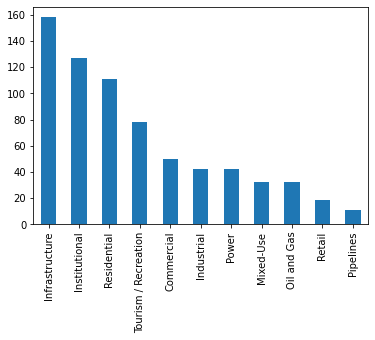

In [19]:
data.Sector.value_counts().plot.bar()

### (Public) Infrastructure Sector

<AxesSubplot:title={'center':'Estimated Cost (millions)'}, xlabel='Type'>

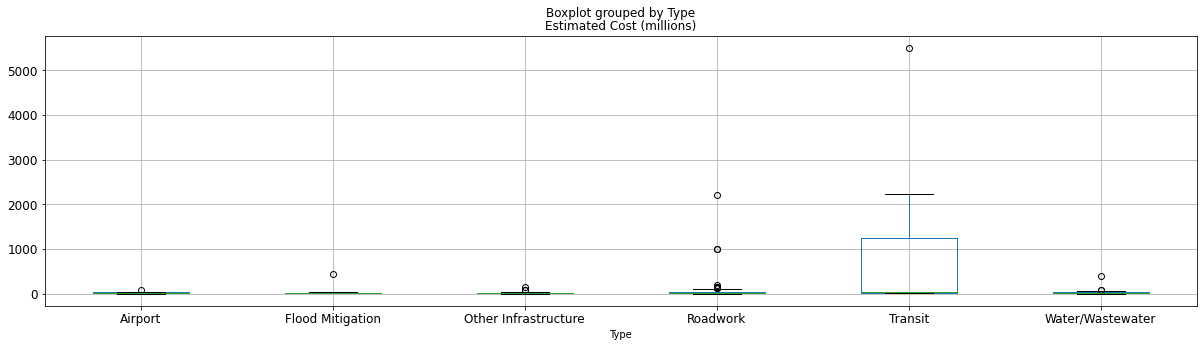

In [20]:
data.loc[(data['Sector']=='Infrastructure') & (data['Type']=='Other'), 'Type']='Other Infrastructure'
data[data['Sector']=='Infrastructure'].boxplot('Estimated Cost (millions)','Type', figsize = [20, 5], fontsize = 12)

### Institutional Sector

<AxesSubplot:title={'center':'Estimated Cost (millions)'}, xlabel='Type'>

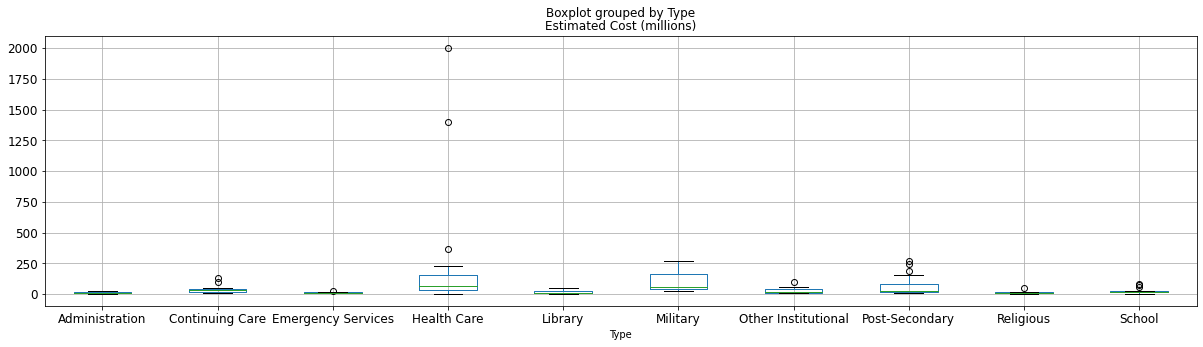

In [21]:
data.loc[(data['Sector']=='Institutional') & (data['Type']=='Other'), 'Type']='Other Institutional'
data[data['Sector']=='Institutional'].boxplot('Estimated Cost (millions)','Type',figsize = [20, 5], fontsize = 12)

### Residential Sector
Corrections: High-Rise above $200m are Community Type and Student Residence is Other Residential Type

In [22]:
data['Type'] = data['Type'].replace('Student Residence','Other')
data.loc[(data['Sector']=='Residential') & (data['Type']=='Other'), 'Type']='Other Residential'
data.loc[(data['Sector']=='Residential') & (data['Type']=='Apartment: High-Rise') & (data['Estimated Cost (millions)']>200), 'Type']='Community'

<AxesSubplot:title={'center':'Estimated Cost (millions)'}, xlabel='Type'>

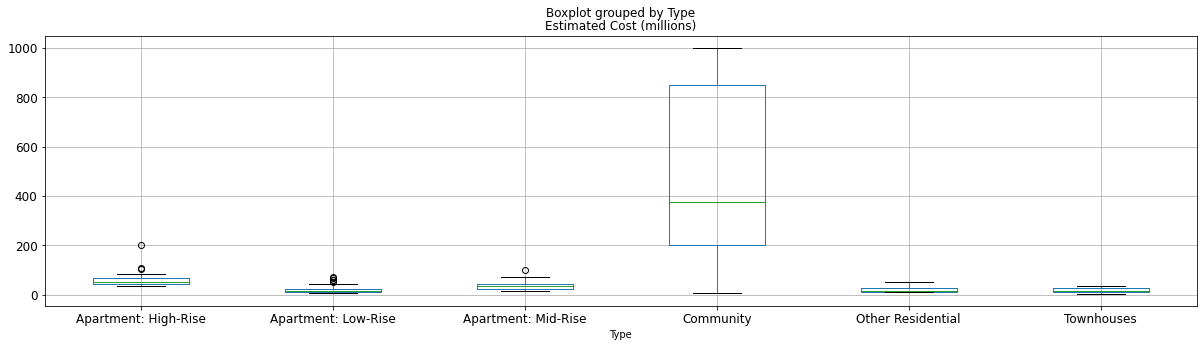

In [23]:
data[data['Sector']=='Residential'].boxplot('Estimated Cost (millions)','Type',figsize = [20, 5], fontsize = 12)

### Tourism Sector
Correction: Museum is an Attractions Type and Tourism is the Sector

In [24]:
data['Sector'] = data['Sector'].replace('Tourism / Recreation','Tourism')
data.loc[(data['Sector']=='Tourism') & (data['Type']=='Other'), 'Type']='Other Tourism'
data['Type'] = data['Type'].replace('Museum','Attractions')

<AxesSubplot:title={'center':'Estimated Cost (millions)'}, xlabel='Type'>

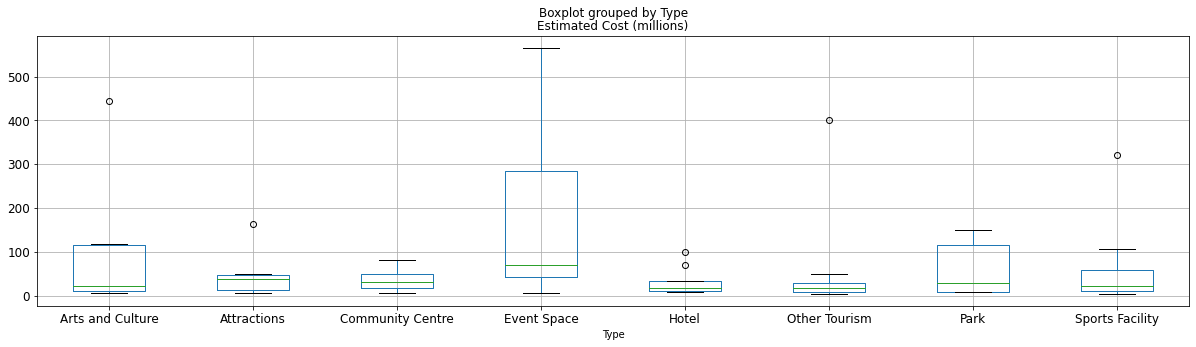

In [25]:
data[data['Sector']=='Tourism'].boxplot('Estimated Cost (millions)','Type',figsize = [20, 5], fontsize = 12)

### Commercial Sector
Correction: There is only Office Low-Rise Type, renamed to Offices

<AxesSubplot:title={'center':'Estimated Cost (millions)'}, xlabel='Type'>

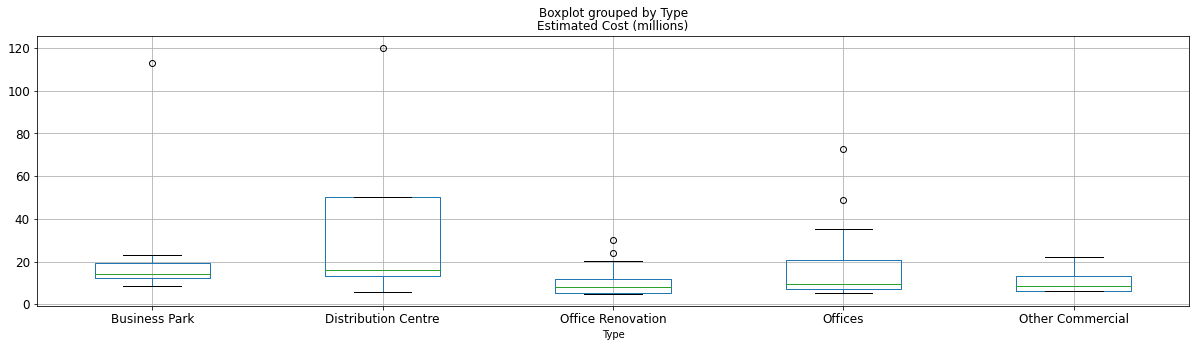

In [26]:
data.loc[(data['Sector']=='Commercial') & (data['Type']=='Other'), 'Type']='Other Commercial'
data['Type'] = data['Type'].replace('Office: Low-Rise','Offices')
data[data['Sector']=='Commercial'].boxplot('Estimated Cost (millions)','Type', figsize = [20, 5], fontsize = 12)

### Power Sector
Corrections: Bioenergy and Transmisson Line Types renamed to Other

<AxesSubplot:title={'center':'Estimated Cost (millions)'}, xlabel='Type'>

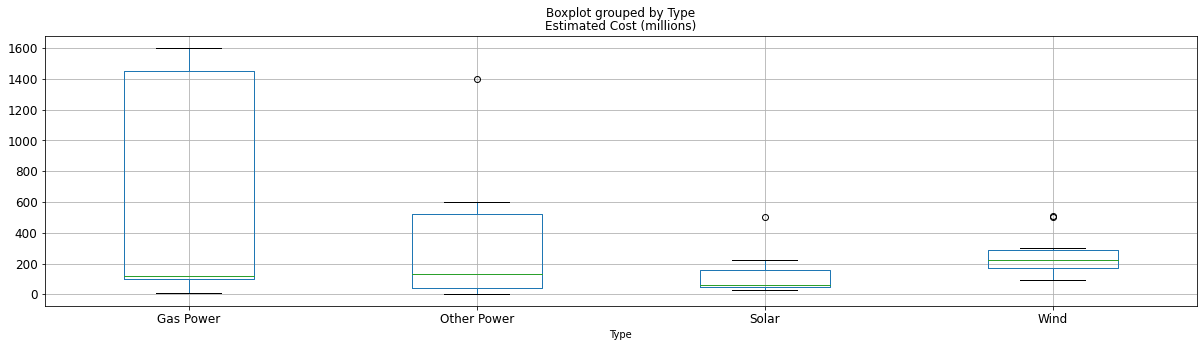

In [27]:
data['Type'] = data['Type'].replace('Bioenergy','Other')
data['Type'] = data['Type'].replace('Natural Gas','Gas Power')
data['Type'] = data['Type'].replace('Transmission Line','Other')
data.loc[(data['Sector']=='Power') & (data['Type']=='Other'), 'Type']='Other Power'
data[data['Sector']=='Power'].boxplot('Estimated Cost (millions)','Type', figsize = [20, 5], fontsize = 12)

### Industrial Sector
Correction: Research Centre Type renamed to Other Industrial Type

<AxesSubplot:title={'center':'Estimated Cost (millions)'}, xlabel='Type'>

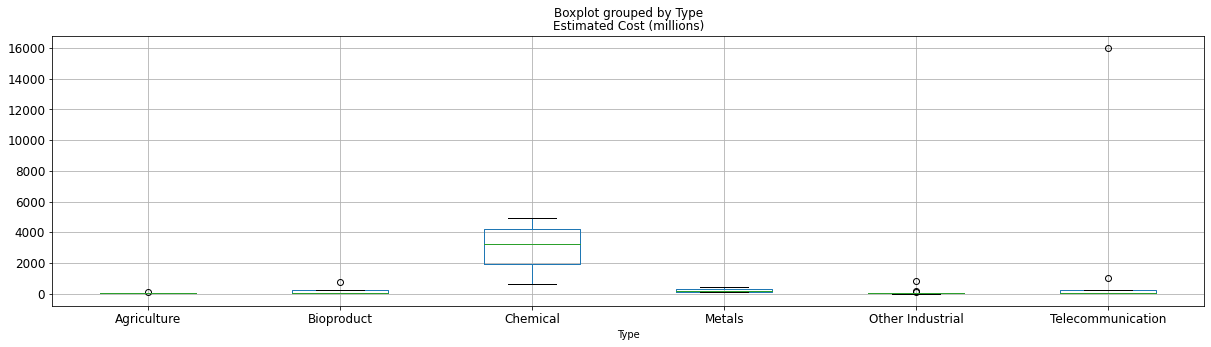

In [28]:
data['Type'] = data['Type'].replace('Research Centre','Other')
data.loc[(data['Sector']=='Industrial') & (data['Type']=='Other'), 'Type']='Other Industrial'
data[data['Sector']=='Industrial'].boxplot('Estimated Cost (millions)','Type', figsize = [20, 5], fontsize = 12)

### Oil and Gas Sector (Including Pipelines)

<AxesSubplot:title={'center':'Estimated Cost (millions)'}, xlabel='Type'>

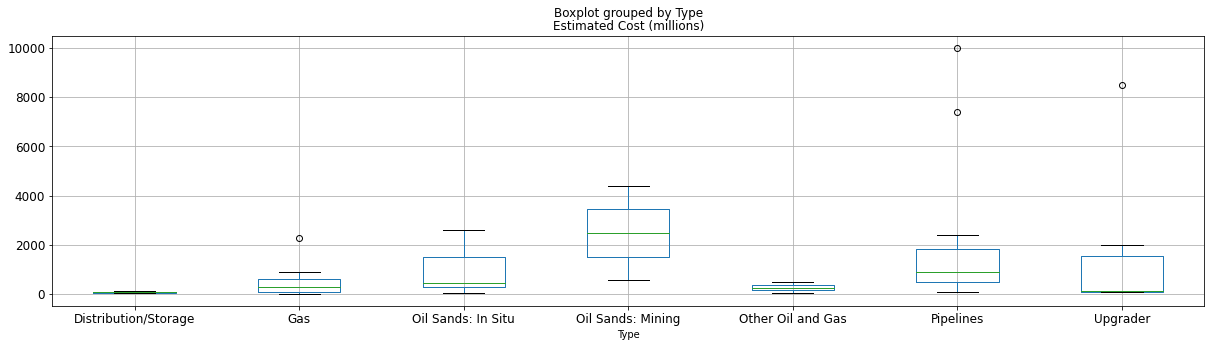

In [29]:
data['Sector'] = data['Sector'].replace('Pipelines','Oil and Gas')
data.loc[(data['Sector']=='Oil and Gas') & (data['Type']=='Other'), 'Type']='Other Oil and Gas'
data[data['Sector']=='Oil and Gas'].boxplot('Estimated Cost (millions)','Type', figsize = [20, 5], fontsize = 12)

### Retail Sector (Including Mixed-Use)
Correction: Power Centre Type renamed to Mixed-Use

<AxesSubplot:title={'center':'Estimated Cost (millions)'}, xlabel='Type'>

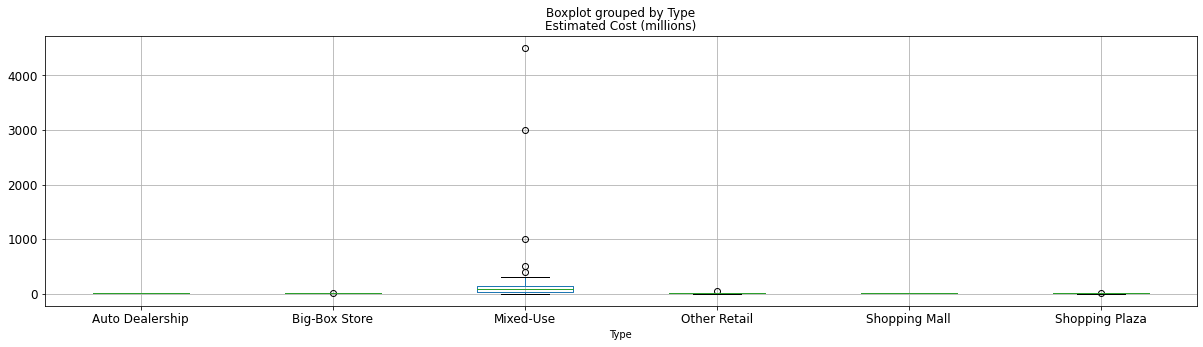

In [30]:
data['Sector'] = data['Sector'].replace('Mixed-Use','Retail')
data.loc[(data['Sector']=='Retail') & (data['Type']=='Other'), 'Type']='Other Retail'
data['Type'] = data['Type'].replace('Power Centre','Mixed-Use')
data[data['Sector']=='Retail'].boxplot('Estimated Cost (millions)','Type', figsize = [20, 5], fontsize = 12)

### Number of Unique Sectors and Types (after corrections)

In [31]:
print('Number of Unique Sectors:',len(data.Sector.unique()))
print('Number of Unique Types:',len(data.Type.unique()))

Number of Unique Sectors: 9
Number of Unique Types: 58


In [32]:
data[['Sector', 'Type', 'Project Name']].groupby(by=['Sector','Type']).count()

Project Name
Sector         Type                              
Commercial     Business Park                   10
               Distribution Centre              5
               Office Renovation               13
               Offices                         18
               Other Commercial                 4
Industrial     Agriculture                      7
               Bioproduct                       4
               Chemical                         4
               Metals                           4
               Other Industrial                14
               Telecommunication                9
Infrastructure Airport                          4
               Flood Mitigation                10
               Other Infrastructure            16
               Roadwork                        79
               Transit                         12
               Water/Wastewater                37
Institutional  Administration                   9
               Continuing Care                 22
               Emergency Services              15
               Health Care                     16
               Library                          3
               Military                         3
               Other Institutional              7
               Post-Secondary                  21
               Religious                        8
               School                          23
Oil and Gas    Distribution/Storage             2
               Gas                              7
               Oil Sands: In Situ              13
               Oil Sands: Mining                2
               Other Oil and Gas                2
               Pipelines                       11
               Upgrader                         6
Power          Gas Power                        7
               Other Power                      8
               Solar                           17
               Wind                            10
Residential    Apartment: High-Rise            18
               Apartment: Low-Rise             61
               Apartment: Mid-Rise             14
               Community                        6
               Other Residential                4
               Townhouses                       8
Retail         Auto Dealership                  2
               Big-Box Store                    5
               Mixed-Use                       33
               Other Retail                     4
               Shopping Mall                    2
               Shopping Plaza                   5
Tourism        Arts and Culture                 9
               Attractions                      8
               Community Centre                 4
               Event Space                      7
               Hotel                           12
               Other Tourism                    9
               Park                             5
               Sports Facility                 24

### Create map of Alberta using latitude and longitude values

In [33]:
AB_Coordinates = [54.5, -115]
AB_Projects_map = folium.Map(location=AB_Coordinates, zoom_start=6)
# add markers to map
for lat, lng, Name, Sector, Type in zip(data['Start Latitude'], data['Start Longitude'], data['Project Name'], data['Sector'], data['Type']):
    label = '{}, {}'.format(Name, Type)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],radius=5,popup=label,color='blue',fill=True,fill_color='#3186cc',fill_opacity=0.7,parse_html=False).add_to(AB_Projects_map)  
    
AB_Projects_map

In [34]:
data.head()

,Project Name,Estimated Cost (millions),Municipality,Forecasted Completion,Sector,Type,Stage,Developer,Start Latitude,Start Longitude
ProjectId,,,,,,,,,,
7,StoneGate Landing,3000.0,Calgary,2021,Retail,Mixed-Use,Started,WAM Development Group / AIMCo,51.172501,-113.975800
11,Shepard Station Suburban Office Campus Building 1,22.0,Calgary,2020,Commercial,Offices,Started,Shepard Development Corp.,50.931721,-113.970596
22,Barron Building Renovation,100.0,Calgary,2021,Residential,Apartment: Mid-Rise,Proposed,Strategic Group,51.046070,-114.076614
26,Quarry Crossing II Office Building,72.8,Calgary,2027,Commercial,Offices,Proposed,Remington Development Corp.,50.966900,-114.002899
32,Nolan Hill TownHomes,5.0,Calgary,2027,Residential,Townhouses,Proposed,Jayman Modus,51.162041,-114.160912


## Save the clean dataset to a SQLite Database and Excel

In [35]:
# conn = sqlite3.connect("Major_Projects.db")
# data.to_sql("MPdata", conn, if_exists="replace")
data.to_excel('MPData.xlsx', sheet_name='Major Projects')

## Major Project Data Preparation

### Cluster Projects (By Cost and Type)

In [36]:
# one hot encoding
onehotcost = pd.get_dummies(data[['Type']], prefix="", prefix_sep="")
# add back estimated cost
onehotcost['Estimated Cost (millions)'] = data['Estimated Cost (millions)']
print(onehotcost.shape)
onehotcost.head()

(702, 59)


,Administration,Agriculture,Airport,Apartment: High-Rise,Apartment: Low-Rise,Apartment: Mid-Rise,Arts and Culture,Attractions,Auto Dealership,Big-Box Store,...,Shopping Plaza,Solar,Sports Facility,Telecommunication,Townhouses,Transit,Upgrader,Water/Wastewater,Wind,Estimated Cost (millions)
ProjectId,,,,,,,,,,,,,,,,,,,,,
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3000.0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,22.0
22,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,100.0
26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,72.8
32,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,5.0


In [37]:
# set number of clusters
kclusters = 10

# run k-means clustering
kmeans = KMeans(init = "k-means++", n_clusters=kclusters, random_state=1234).fit(onehotcost)

# check how many cluster labels were generated for each row in the dataframe
len(kmeans.labels_)

702

In [38]:
# add clustering labels
onehotcost.insert(0, 'Cluster', kmeans.labels_)
onehotcost.head()

,Cluster,Administration,Agriculture,Airport,Apartment: High-Rise,Apartment: Low-Rise,Apartment: Mid-Rise,Arts and Culture,Attractions,Auto Dealership,...,Shopping Plaza,Solar,Sports Facility,Telecommunication,Townhouses,Transit,Upgrader,Water/Wastewater,Wind,Estimated Cost (millions)
ProjectId,,,,,,,,,,,,,,,,,,,,,
7,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3000.0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,22.0
22,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,100.0
26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,72.8
32,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,5.0


### Compare Cost Clusters with Sectors Groupings
Cluster by cost and Type is an improvement over the Sectors grouping but it is not Hierarchical and it will be more dificult to label (see Feature Eng.)


<AxesSubplot:title={'center':'Estimated Cost (millions)'}, xlabel='Cluster'>

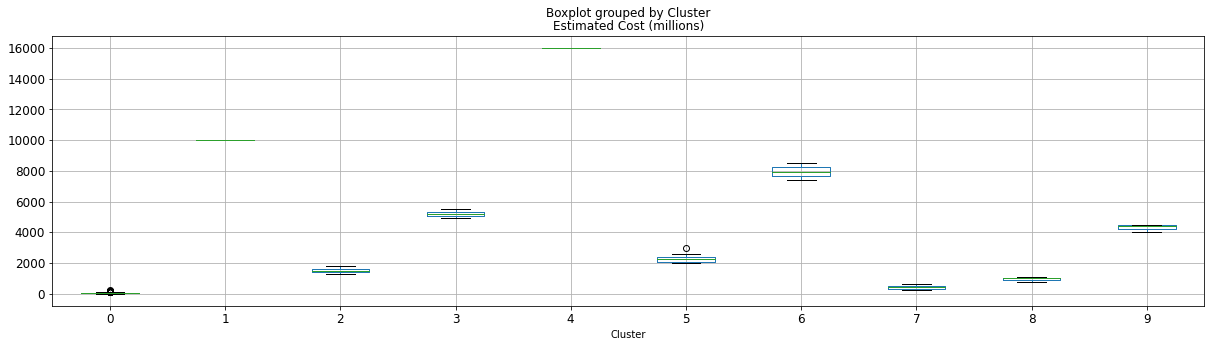

In [39]:
onehotcost.boxplot('Estimated Cost (millions)','Cluster',figsize = [20, 5], fontsize = 12)

<AxesSubplot:title={'center':'Estimated Cost (millions)'}, xlabel='Sector'>

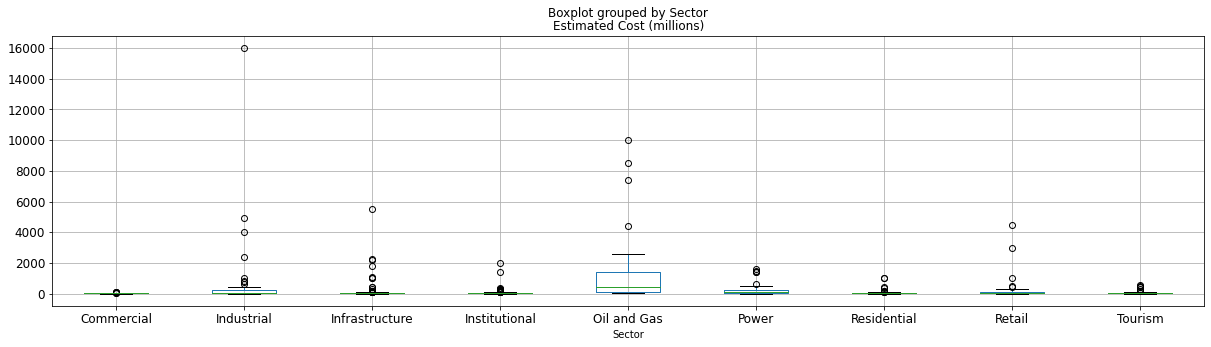

In [40]:
data.boxplot('Estimated Cost (millions)','Sector',figsize = [20, 5], fontsize = 12)

### Cluster Projects by Geographical Region and Type

In [41]:
# one hot encoding
onehotregion = pd.get_dummies(data[['Type']], prefix="", prefix_sep="")
# add back estimated Start Coordinates
onehotregion['Start Latitude'] = data['Start Latitude']
onehotregion['Start Longitude'] = data['Start Longitude']
print(onehotregion.shape)
onehotregion.head()

(702, 60)


,Administration,Agriculture,Airport,Apartment: High-Rise,Apartment: Low-Rise,Apartment: Mid-Rise,Arts and Culture,Attractions,Auto Dealership,Big-Box Store,...,Solar,Sports Facility,Telecommunication,Townhouses,Transit,Upgrader,Water/Wastewater,Wind,Start Latitude,Start Longitude
ProjectId,,,,,,,,,,,,,,,,,,,,,
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,51.172501,-113.975800
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,50.931721,-113.970596
22,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,51.046070,-114.076614
26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,50.966900,-114.002899
32,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,51.162041,-114.160912


In [42]:
# set number of clusters
kclusters = 10

# run k-means clustering
kmeans = KMeans(init = "k-means++", n_clusters=kclusters, random_state=123).fit(onehotregion)

# check how many cluster labels were generated for each row in the dataframe
len(kmeans.labels_)

702

In [43]:
# add Region labels
onehotregion.insert(0, 'Region', kmeans.labels_)
onehotregion.head()

,Region,Administration,Agriculture,Airport,Apartment: High-Rise,Apartment: Low-Rise,Apartment: Mid-Rise,Arts and Culture,Attractions,Auto Dealership,...,Solar,Sports Facility,Telecommunication,Townhouses,Transit,Upgrader,Water/Wastewater,Wind,Start Latitude,Start Longitude
ProjectId,,,,,,,,,,,,,,,,,,,,,
7,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,51.172501,-113.975800
11,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,50.931721,-113.970596
22,8,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,51.046070,-114.076614
26,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,50.966900,-114.002899
32,8,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,51.162041,-114.160912


### Add back Project Name and Cost

In [44]:
onehotregion['Estimated Cost (millions)'] = data['Estimated Cost (millions)']
onehotregion['Project Name'] = data['Project Name']

# move Project Name column to the first column
fixed_columns = [onehotregion.columns[-1]] + list(onehotregion.columns[:-1])
onehotregion = onehotregion[fixed_columns]

### Create a new Map color coded by Region

In [45]:
# create map
map_region = folium.Map(location=AB_Coordinates, zoom_start=6)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, name, region in zip(onehotregion['Start Latitude'], onehotregion['Start Longitude'], onehotregion['Project Name'], onehotregion['Region']):
    label = folium.Popup(str(name) + ' Region ' + str(region), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[region-1],
        fill=True,
        fill_color=rainbow[region-1],
        fill_opacity=0.7).add_to(map_region)
       
map_region

### Label the regions by the main city or towns nearby

In [46]:
onehotregion['Region'] = onehotregion['Region'].replace({0: 'Edmonton', 1: 'Calgary', 2: 'Lloydminster-Bonnyville', 3:'Grande Prairie', 4:'Medicine Hat',
                                         5:'Fort McMurray', 6:'Peace River-High Level', 7:'Lethbridge', 8:'Jasper-Whitecourt', 9:'Red Deer'})
print(onehotregion.shape)
onehotregion.head()

(702, 63)


,Project Name,Region,Administration,Agriculture,Airport,Apartment: High-Rise,Apartment: Low-Rise,Apartment: Mid-Rise,Arts and Culture,Attractions,...,Sports Facility,Telecommunication,Townhouses,Transit,Upgrader,Water/Wastewater,Wind,Start Latitude,Start Longitude,Estimated Cost (millions)
ProjectId,,,,,,,,,,,,,,,,,,,,,
7,StoneGate Landing,Jasper-Whitecourt,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,51.172501,-113.975800,3000.0
11,Shepard Station Suburban Office Campus Building 1,Jasper-Whitecourt,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,50.931721,-113.970596,22.0
22,Barron Building Renovation,Jasper-Whitecourt,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,51.046070,-114.076614,100.0
26,Quarry Crossing II Office Building,Jasper-Whitecourt,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,50.966900,-114.002899,72.8
32,Nolan Hill TownHomes,Jasper-Whitecourt,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,51.162041,-114.160912,5.0


### Feature Engineering

The Size and/or Capacity varies depending of the Project Type, the numbers were extracted from the Project details and units were cleaned manually in excel.
The Target variable is set from a range in relation to Average Cost/Capacity per Project Type. 

In [85]:
TData = pd.read_excel('./Target_Data.xlsx')
TData.set_index('ProjectId', inplace=True)
TData.drop(columns={'Estimated Cost (millions)','Type'}, inplace=True)
TData['Size/Capacity'] = TData['Size/Capacity'].fillna(0)
print(TData.shape)
TData.head()

(702, 6)


,Size/Capacity,Units,$1000/Capacity,Low (70%),High (150%),Target
ProjectId,,,,,,
7,11000000.0,sqft,0.272727,0.303092,0.649482,Too Cheap
11,850000.0,sqft,0.025882,0.186559,0.399770,Too Cheap
22,250000.0,sqft,0.400000,0.280000,0.600000,In the Range
26,512000.0,sqft,0.142187,0.186559,0.399770,Too Cheap
32,150000.0,sqft,0.033333,0.023333,0.050000,In the Range


### Store the Target Variable

In [126]:
Target = TData['Target']
Target.shape

(702,)

### Merge Datasets and add Sector

In [127]:
MPTData = pd.merge(onehotregion,TData,left_index=True,right_index=True)
MPTData['Sector'] = data['Sector']
MPTData.head()

,Project Name,Region,Administration,Agriculture,Airport,Apartment: High-Rise,Apartment: Low-Rise,Apartment: Mid-Rise,Arts and Culture,Attractions,...,Start Latitude,Start Longitude,Estimated Cost (millions),Size/Capacity,Units,$1000/Capacity,Low (70%),High (150%),Target,Sector
ProjectId,,,,,,,,,,,,,,,,,,,,,
7,StoneGate Landing,Jasper-Whitecourt,0,0,0,0,0,0,0,0,...,51.172501,-113.975800,3000.0,11000000.0,sqft,0.272727,0.303092,0.649482,Too Cheap,Retail
11,Shepard Station Suburban Office Campus Building 1,Jasper-Whitecourt,0,0,0,0,0,0,0,0,...,50.931721,-113.970596,22.0,850000.0,sqft,0.025882,0.186559,0.399770,Too Cheap,Commercial
22,Barron Building Renovation,Jasper-Whitecourt,0,0,0,0,0,1,0,0,...,51.046070,-114.076614,100.0,250000.0,sqft,0.400000,0.280000,0.600000,In the Range,Residential
26,Quarry Crossing II Office Building,Jasper-Whitecourt,0,0,0,0,0,0,0,0,...,50.966900,-114.002899,72.8,512000.0,sqft,0.142187,0.186559,0.399770,Too Cheap,Commercial
32,Nolan Hill TownHomes,Jasper-Whitecourt,0,0,0,0,0,0,0,0,...,51.162041,-114.160912,5.0,150000.0,sqft,0.033333,0.023333,0.050000,In the Range,Residential


### One big hot encoding for Region, Units and Sector & Drop not required features

In [88]:
onebighot = pd.get_dummies(data=MPTData, columns=['Region','Units','Sector'], prefix="", prefix_sep="")
onebighot.drop(columns={'Project Name','$1000/Capacity','Low (70%)','High (150%)','Target'}, inplace=True)
onebighot.columns

Index(['Administration', 'Agriculture', 'Airport', 'Apartment: High-Rise',
       'Apartment: Low-Rise', 'Apartment: Mid-Rise', 'Arts and Culture',
       'Attractions', 'Auto Dealership', 'Big-Box Store', 'Bioproduct',
       'Business Park', 'Chemical', 'Community', 'Community Centre',
       'Continuing Care', 'Distribution Centre', 'Distribution/Storage',
       'Emergency Services', 'Event Space', 'Flood Mitigation', 'Gas',
       'Gas Power', 'Health Care', 'Hotel', 'Library', 'Metals', 'Military',
       'Mixed-Use', 'Office Renovation', 'Offices', 'Oil Sands: In Situ',
       'Oil Sands: Mining', 'Other Commercial', 'Other Industrial',
       'Other Infrastructure', 'Other Institutional', 'Other Oil and Gas',
       'Other Power', 'Other Residential', 'Other Retail', 'Other Tourism',
       'Park', 'Pipelines', 'Post-Secondary', 'Religious', 'Roadwork',
       'School', 'Shopping Mall', 'Shopping Plaza', 'Solar', 'Sports Facility',
       'Telecommunication', 'Townhouses', 'Tra

# Decision Tree Classifier

Split the dataset 70% for Training and 30% for Testing the Decision Tree. 

In [134]:
# X = StandardScaler().fit_transform(onebighot) # Scaled version
# Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Target, test_size=0.3, random_state=3)

# Unscaled version
Xtrain, Xtest, Ytrain, Ytest = train_test_split(onebighot, Target, test_size=0.3, random_state=3)

print('X train:',Xtrain.shape), print('X test:',Xtest.shape)
print('Y train:',Ytrain.shape), print('Y test:',Ytest.shape)

X train: (491, 89)
X test: (211, 89)
Y train: (491,)
Y test: (211,)


(None, None)

### Create the Decision Tree Classifier and train the model

In [135]:
MPTree = DecisionTreeClassifier(criterion="entropy", max_depth = 20)
MPTree.fit(Xtrain,Ytrain)

DecisionTreeClassifier(criterion='entropy', max_depth=20)

### Make a Prediction with the test set

In [136]:
PTree = MPTree.predict(Xtest)
PTree.shape

(211,)

In [137]:
print("Decision Tree Accuracy: ", metrics.accuracy_score(Ytest, PTree))

Decision Tree Accuracy:  0.8909952606635071


### Visualization

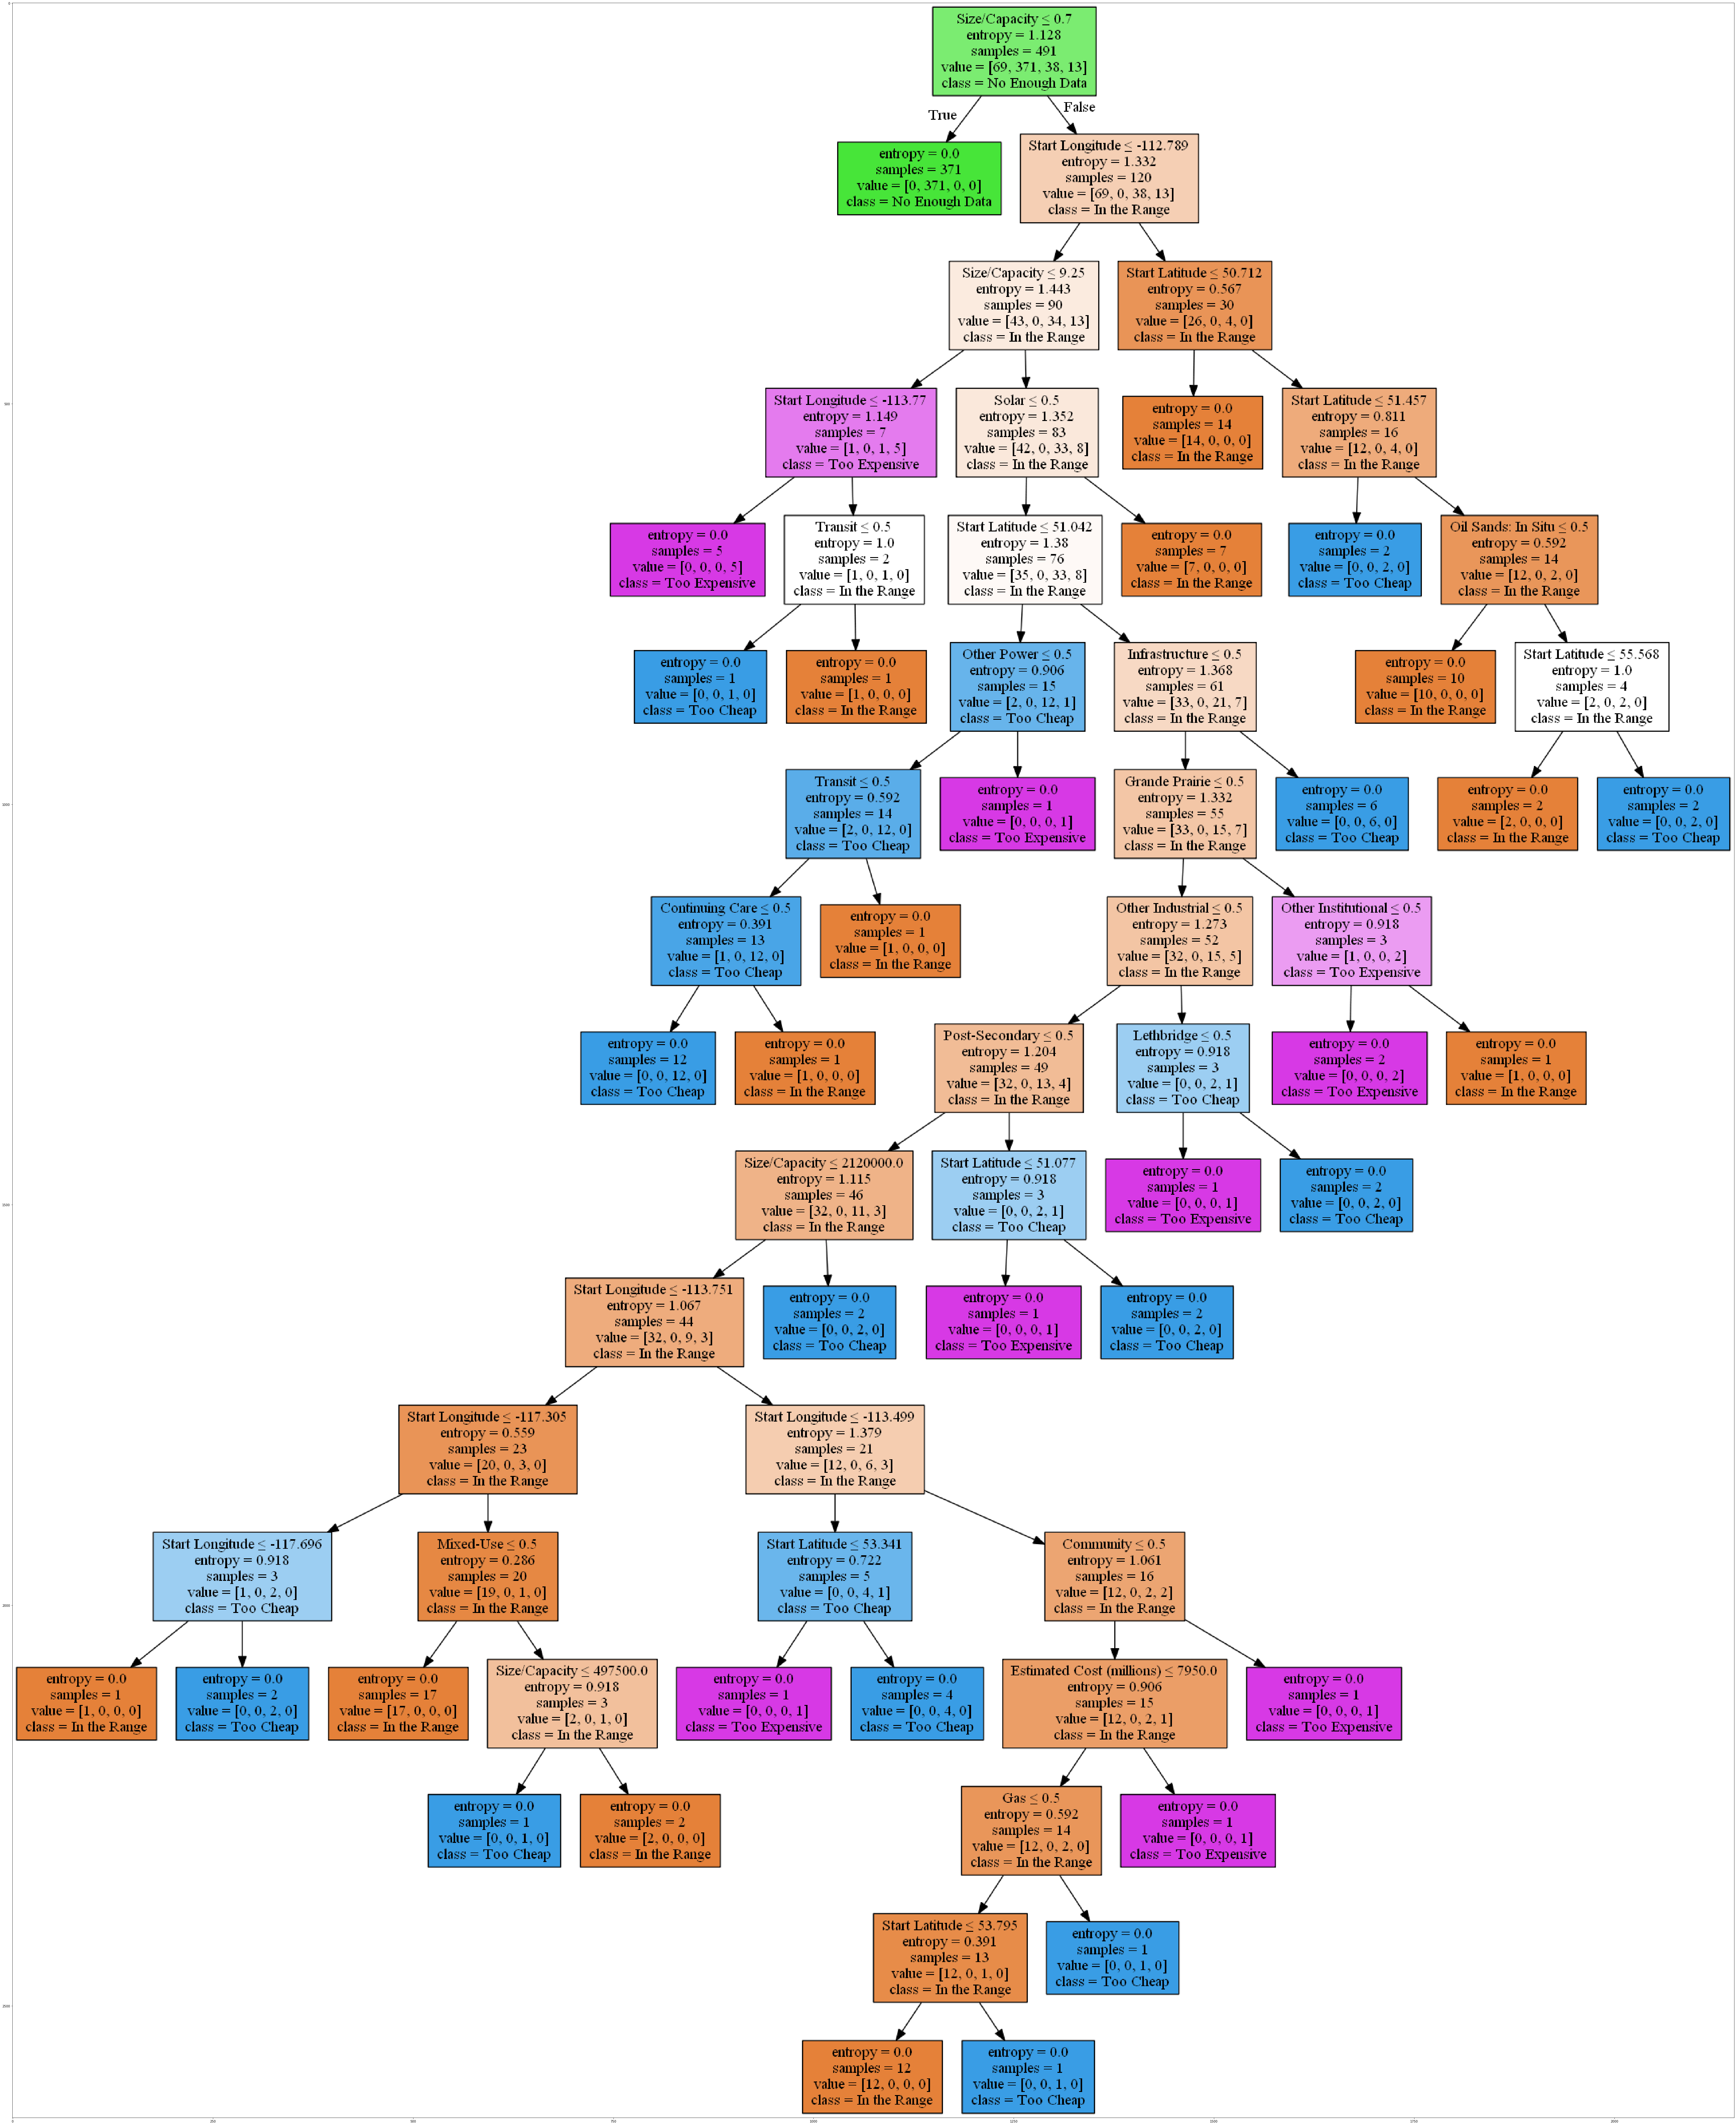

In [138]:
%matplotlib inline
dot_data = io.StringIO()
filename = "MajorProjectTree.png"
featureNames = onebighot.columns
targetNames = TData['Target'].unique().tolist()
out=tree.export_graphviz(MPTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(Ytrain), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')